# Code Part

## Download Dataset


In [ ]:
!pip -q install wfdb==3.4.0 
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -qo /content/mit-bih-arrhythmia-database-1.0.0.zip 

     |████████████████████████████████| 137 kB 5.4 MB/s 


## Change the ECG Signal

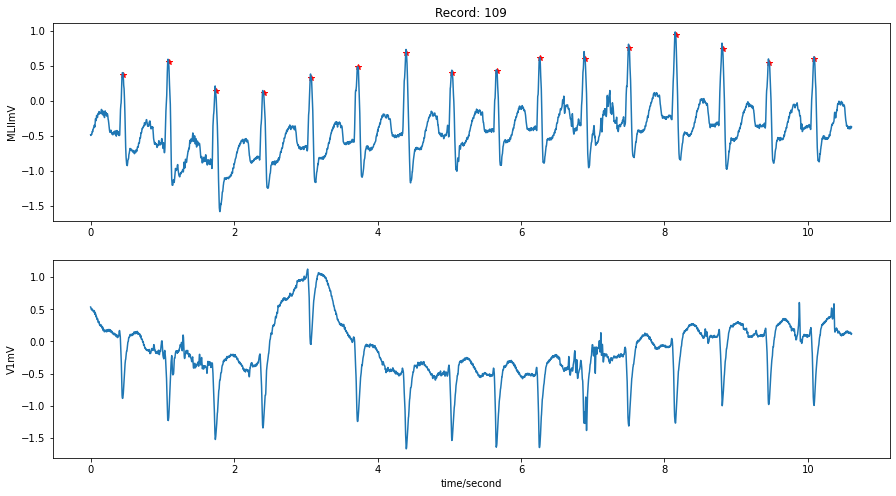

In [ ]:
#@title Choose ECG Signal { form-width: "20%", display-mode: "both" }
signal_number = 9 #@param {type:"slider", min:0, max:9, step:1}
import wfdb
import numpy as np
import pandas as pd

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(100 + signal_number)}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)    
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000,shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

## QRS Detection
(3marks)

In [ ]:
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    In band pass filter, first low pass filter is implemented using the diffrence
    equation y(nT) = 2y(nT - T) - y(nT - 2 T) + x(nT)- 2x(nT- 6T)+x(nT- 12T)
    Result of this filter is given as input to high pass filter. High pass filter 
    is implemented by using difference equation 
    y(nT) = 32x(nT - 16 T) - [y(nT - T)+ x(nT) - x(nT - 32 T)]
    Both filter are implemented recursively giving bandpass filter together. 
    '''
    #[TODO]
    #low pass filter
    y=signal.copy()
    for n in signal.index:
        if(n >= 12):
            y.iloc[n,1] = 2*y.iloc[n-1,1] - y.iloc[n-2,1] + signal.iloc[n,1] - 2*signal.iloc[n-6,1] + signal.iloc[n-12,1] 
        if(n<12 and n>= 6):
            y.iloc[n,1]= 2*y.iloc[n-1,1] - y.iloc[n-2,1] + signal.iloc[n,1] - 2*signal.iloc[n-6,1] 
        if(n<6 and n>=2):
            y.iloc[n,1]= 2*y.iloc[n-1,1] - y.iloc[n-2,1] + signal.iloc[n,1] 
        if(n<2 and n>=1):
            y.iloc[n,1]= 2*y.iloc[n-1,1] + signal.iloc[n,1]
	  
    #high pass filter
    z=y.copy()
    for n in y.index:
        if(n >= 32):
            z.iloc[n,1] = y.iloc[n-32,1]- z.iloc[n-1,1] - y.iloc[n,1] + 32*y.iloc[n-16,1]
        if(n<32 and n>=16):
            z.iloc[n,1] = 32*y.iloc[n-16,1]- z.iloc[n-1,1] - y.iloc[n,1] 
        if(n<16 and n>=1):
            z.iloc[n,1] = - z.iloc[n-1,1] - y.iloc[n,1] 
    return z
    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    differentiation is implemented by using five-point differentiation stratagy.
    Equation for which is 
    y(nT) = (1/8 T) [-x(nT - 2 T) - 2x(nT - T)+ 2x(nT + T) +x(nT+ 2T)].
    '''
    #[TODO]
    x=signal.copy()
    for n in range(2,len(signal)-2):
        x.iloc[n,1]= (-signal.iloc[n-2,1]-2*signal.iloc[n-1,1]+2*signal.iloc[n+1,1]+signal.iloc[n+2,1])/8
    x.iloc[0,1]=x.iloc[2,1]
    x.iloc[1,1]=x.iloc[2,1]
    x.iloc[len(signal)-2,1]=x.iloc[len(signal)-3,1]
    x.iloc[len(signal)-1,1]=x.iloc[len(signal)-3,1]
    return x

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    simply squared the ECG values by iterating in the dataframe.
    '''
    #[TODO]
    x=signal.copy()
    for n in signal.index:
        x.iloc[n,1]=signal.iloc[n,1]**2
    return x

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    for each point in the dataframe, we have assigned the value which is equal to
    average of last 30 ECG values respective to that point. 
    for first 30 values, we done nothing.
    '''
    #[TODO]
    x=signal.copy()
    w=30
    for n in range(30,len(signal)):
        for i in range(1,w):
            x.iloc[n,1]+=signal.iloc[n-i,1]
        x.iloc[n,1]/=w
    return x
    

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO]
    we simply applied pipeline method. giving ouput of a function as a
    input to other function. In this way, all filters will work one by 
    one to give final ouput. 
    '''
    #[TODO]
    f1=self.band_pass_filter(signal)
    f2=self.derivative(f1)
    f3=self.squaring(f2)
    f4=self.moving_window_integration(f3)
    return f1,f2,f3,f4


QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
filtered_signal, derivative_signal, squared_signal, output_signal = QRS_detector.solve(ecg)

## Calculating Heart Rate
In this section you need to write code to calculate heart rate of the given ecg signal using the help of QRS detected. \\
(1mark)

In [ ]:

sum=0
mean=0
for i in range(100,len(y)):
    sum+=y.iloc[i,1]
mean=sum/(len(y)-100)
inspect=0
rr_list=[]
max=0
a=0
for i in range(100, len(y)):
    if(output_signal.iloc[i,1]<mean and inspect==0):
        continue
    elif(output_signal.iloc[i,1]>=mean):
        inspect=1
        if(output_signal.iloc[i,1]>max):
            max=output_signal.iloc[i,1]
            a=output_signal.iloc[i,0]
    elif(output_signal.iloc[i,1]<mean and inspect==1):
        inspect=0
        rr_list.append(a)
        max=0
list_sum=0
for i in range(len(rr_list)-1):
    list_sum+=rr_list[i+1]-rr_list[i]
rr_average=list_sum/(len(rr_list)-1)
heartrate=60*360/rr_average
print(heartrate)


93.37175792507205


## Plotting the Signals
consider using matlplotlib(or other plotting libraries) to create images for report. Please write code below \\
(1mark)

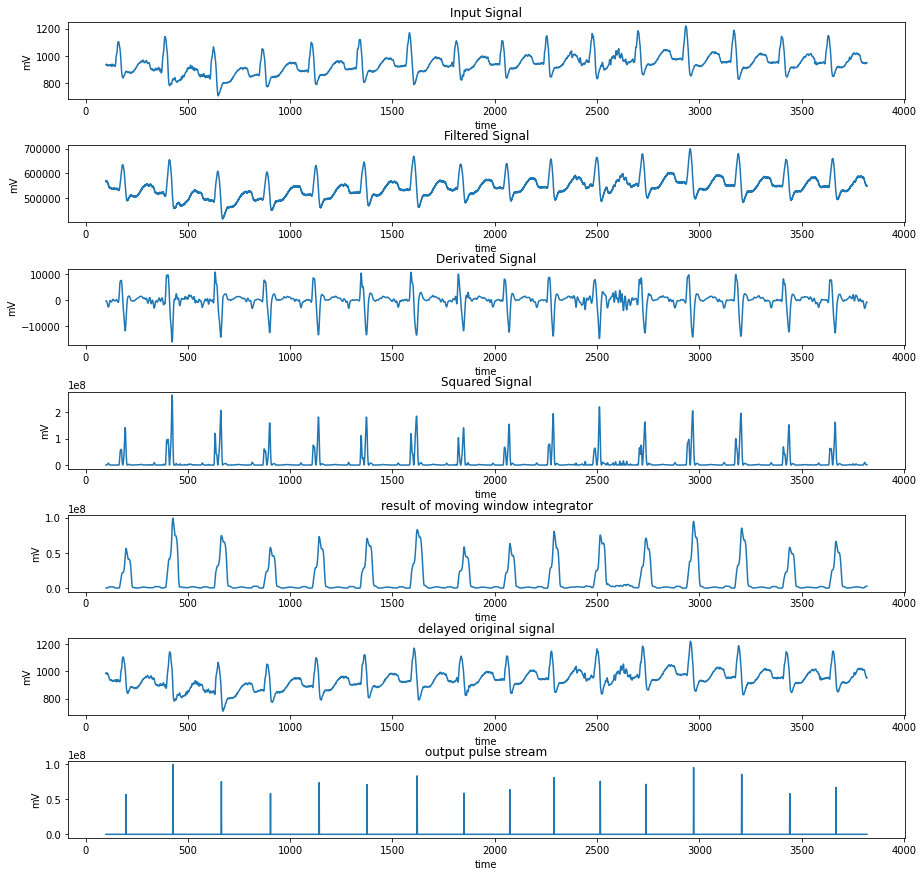

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.subplot(7,1,1)
plt.plot(ecg['TimeStamp'][100:],ecg['ecg'][100:])
plt.title('Input Signal')
plt.xlabel('time')
plt.ylabel('mV')

plt.subplot(7,1,2)
plt.plot(filtered_signal['TimeStamp'][100:],filtered_signal['ecg'][100:])
plt.title('Filtered Signal')
plt.xlabel('time')
plt.ylabel('mV')

plt.subplot(7,1,3)
plt.plot(derivative_signal['TimeStamp'][100:],derivative_signal['ecg'][100:])
plt.title('Derivated Signal')
plt.xlabel('time')
plt.ylabel('mV')

plt.subplot(7,1,4)
plt.plot(squared_signal['TimeStamp'][100:],squared_signal['ecg'][100:])
plt.title('Squared Signal')
plt.xlabel('time')
plt.ylabel('mV')

plt.subplot(7,1,5)
plt.plot(output_signal['TimeStamp'][100:],output_signal['ecg'][100:])
plt.title('result of moving window integrator')
plt.xlabel('time')
plt.ylabel('mV')

delayed_signal=ecg.copy()
for i in range(23,len(ecg)):
    delayed_signal.iloc[i,1]=ecg.iloc[i-23,1]
plt.subplot(7,1,6)
plt.plot(delayed_signal['TimeStamp'][100:],delayed_signal['ecg'][100:])
plt.title('delayed original signal')
plt.xlabel('time')
plt.ylabel('mV')

pulse_stream=ecg.copy()
for i in ecg.index:
    pulse_stream.iloc[i,1]=0
for j in rr_list:
    pulse_stream.iloc[j,1]=output_signal.iloc[j,1]
plt.subplot(7,1,7)
plt.plot(pulse_stream['TimeStamp'][100:],pulse_stream['ecg'][100:])
plt.title('output pulse stream')
plt.xlabel('time')
plt.ylabel('mV')
plt.subplots_adjust(hspace=0.6)

# Report

## Your Understanding of the Algorithm
(2marks)

 Pan Tompkins algorithm is very effective in QRS detection. It has detected
 99.3 percent QRS complex correctly. It initially pass Ecg signal through a bandpass filter. The bandpass filter reduces the influence of muscle noise,
60 Hz interference, baseline wander, and T-wave interference.The desirable passband to maximize the QRS energy is approx-imately 5-15 Hz. we cascaded the low-pass and high-pass filters to achieve a 3 dB passband from about 5-12 Hz.

In th next step, signal is differentiated using five-point differentiation technique. It is done to obtain information about slope of QRS complex. Signal is then squared to intensify the the slope of the frequency response curve of the deriv-ative and helps restrict false positives caused by T waves with higher than usual spectral energies. This makes all data points positive and does nonlinear amplifi-cation of the output of the derivative emphasizing the high frequencies (i.e., predominantly the ECG frequencies).

The purpose of moving-window integration is to obtain wave-form feature information in addition to the slope of the R wave. The moving window inte-
grator produces a signal that includes information about both the slope and the width of the QRS complex. width of the integration window is decided very carefully. If the window is too wide, the integration waveform will merge the -QRS and T complexes together. If it is too narrow, some QRS complexes will produce several peaks in the integration waveform.

After moving-window integretion, we have used different approach for finding heartbeat than the one given in paper. We first found mean of ecg values. After that we whenever our ecg values are grater than mean value, we will find a max value before ecg values again drop below mean value. In this way we will get our peaks. This is very crude methos to find peak values but it works in most of cases. after this, we calculate avarage of difference of timestamps of consecutive peaks. Finally, we calculate heart rate by formula, 

heart rate= 60*sample rate/ RR interval



## Results
(2marks)

You will have to show results for each signal 0-9 for the various filters over them. Do consider properly labeling your plots. Also report ***heart rate*** for each ecg signal.

Note: you can stick pictures, code is not required for this section
![picture](https://i.ibb.co/3C6r4qP/results-eg.png)

*signal number 0**

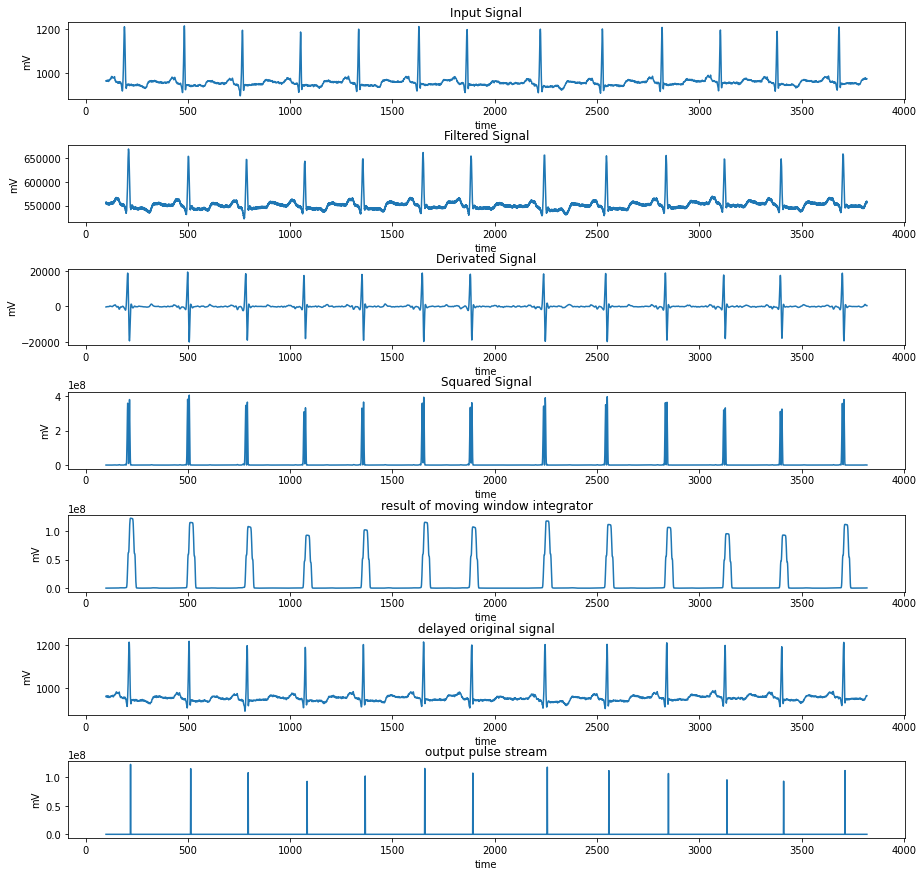

**signal number 1**

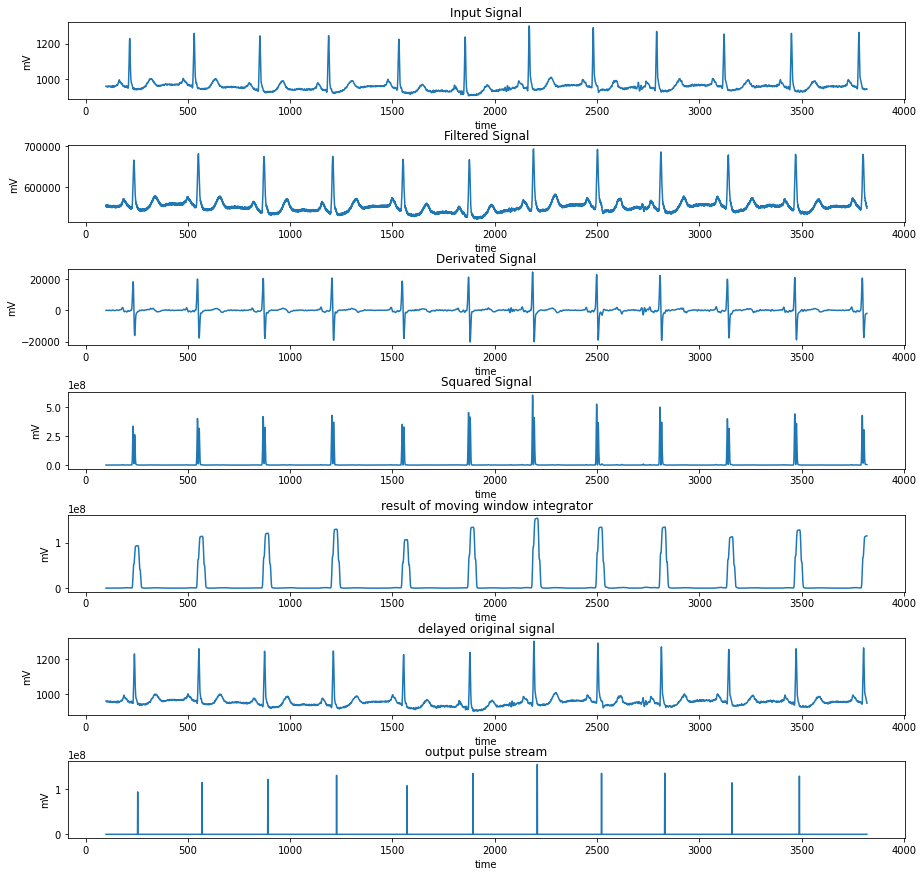

**signal number 2**

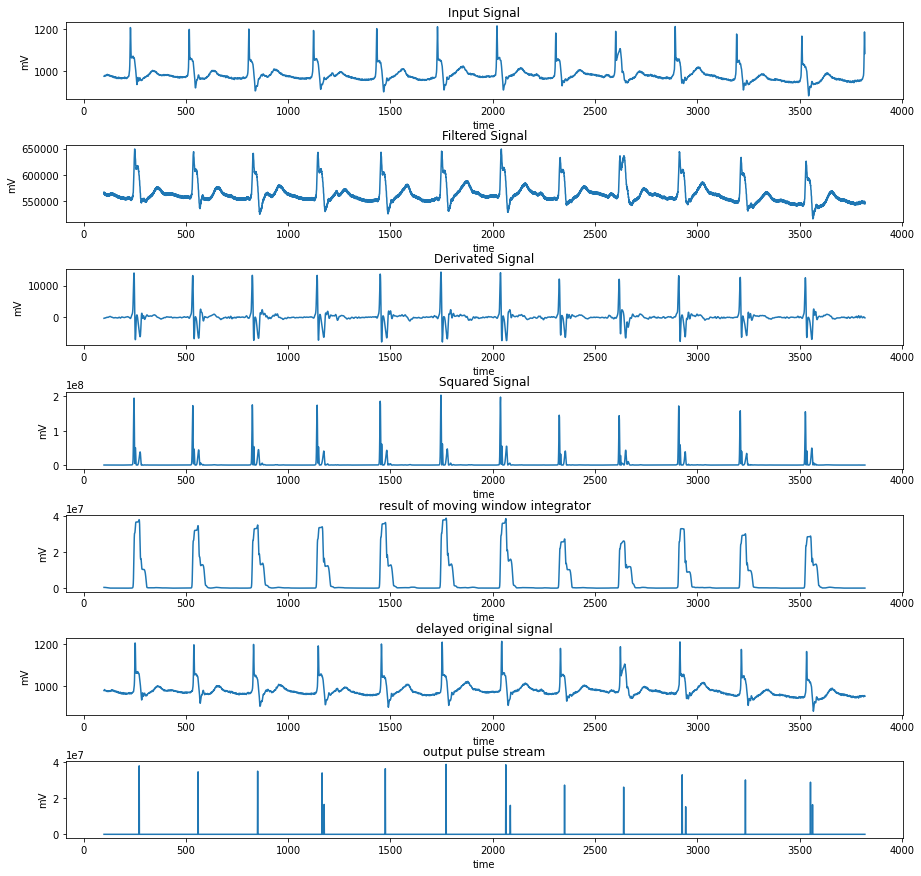

**signal number 3**

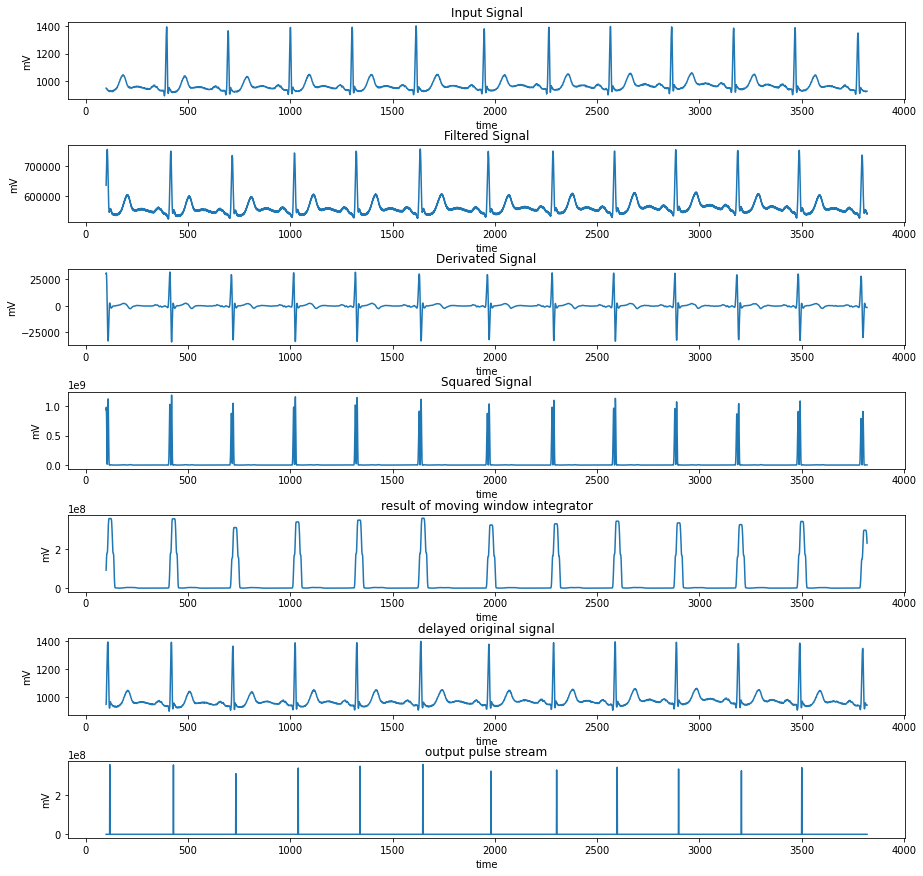

**signal number 4**

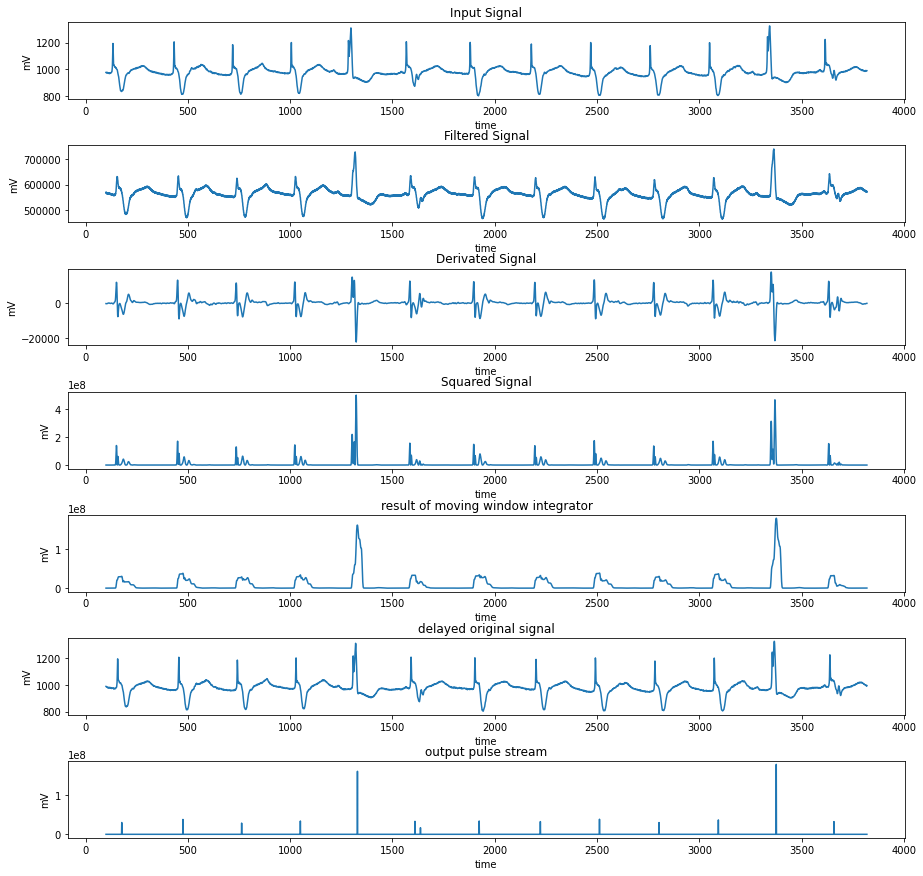

**signal number 5**

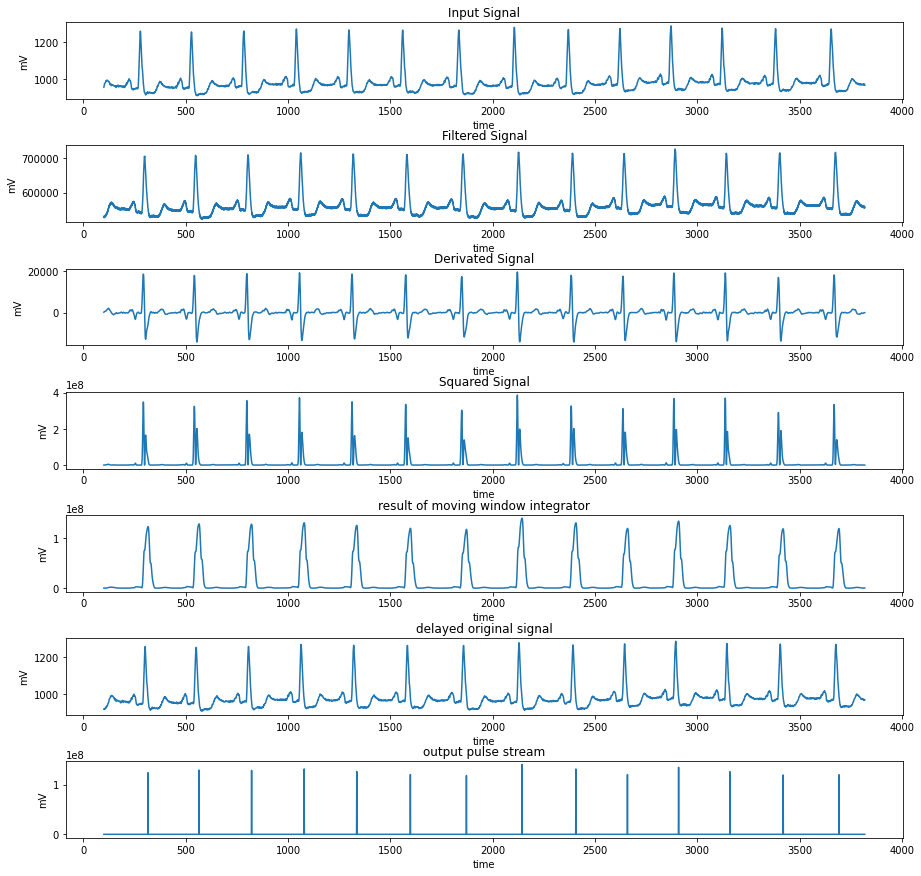

**signal number 6**

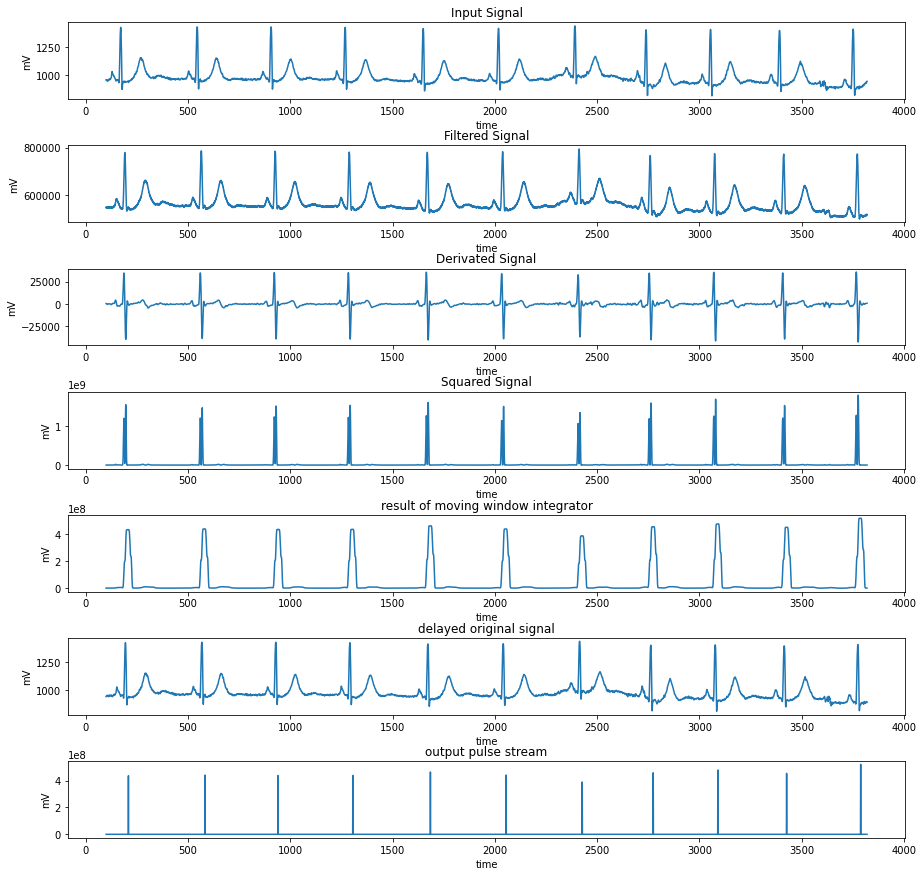

**signal number 7**

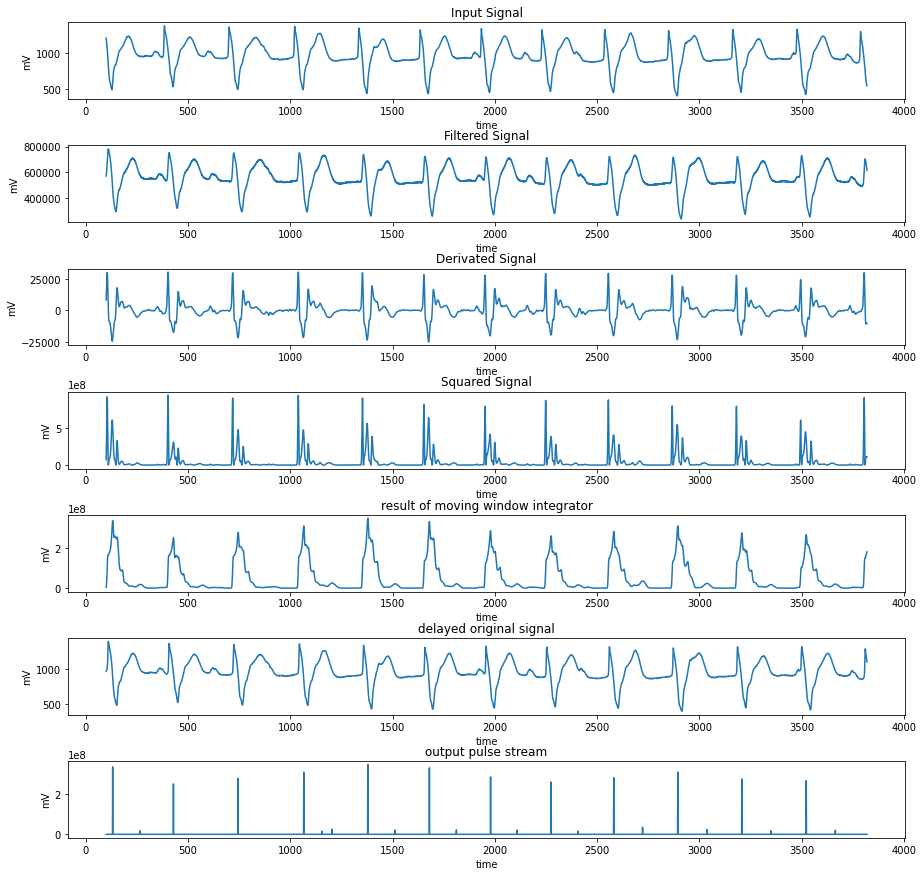

 **signal number 8**

 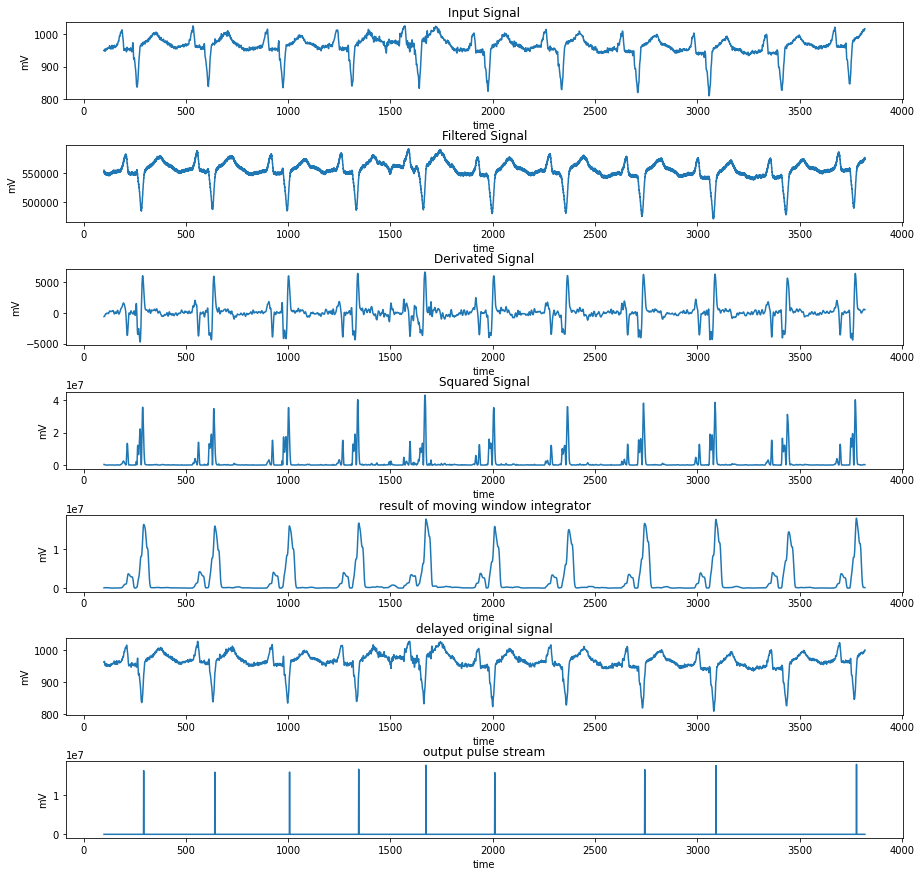

**signal number 9**

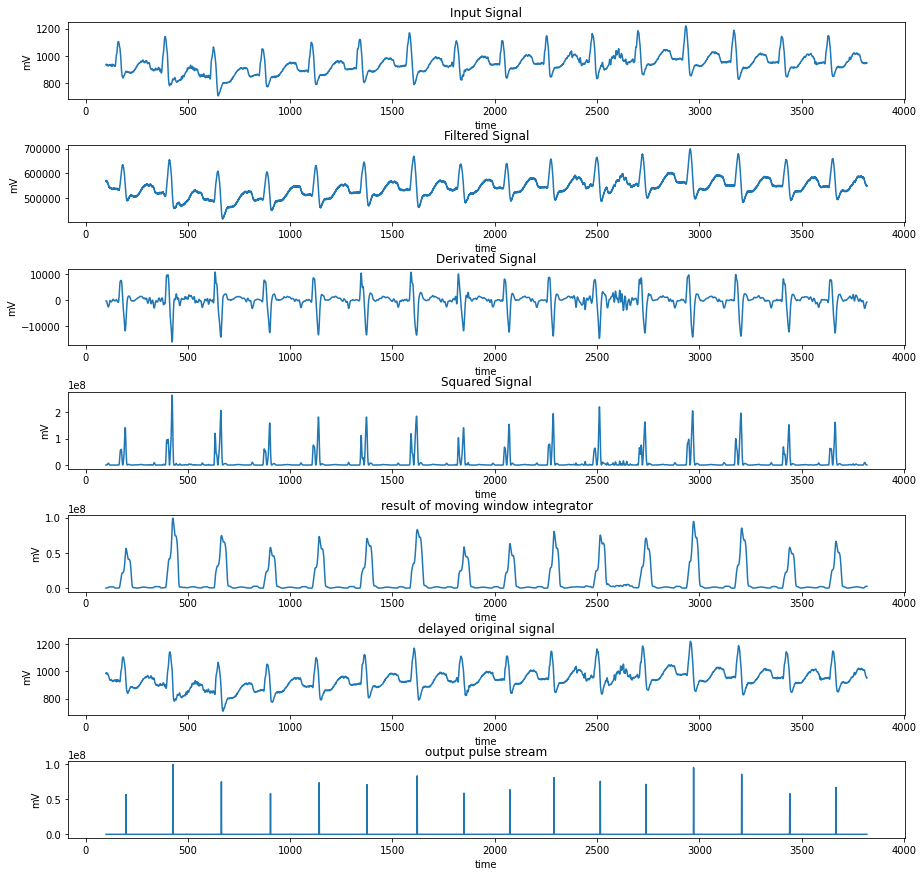

**Heart rate for signals**

number 0= 74.22680412371135

number 1= 66.79035250463822

number 2= 98.4503190519599

number 3= 70.25428740390302

number 4= 80.66647515081873

number 5= 83.15072549600237

number 6= 60.35205364626991

number 7= 134.54133635334088

number 8= 49.598163030998855

number 9= 93.37175792507205

## Conclusion
(1mark)

There are very important points to conclude from this paper and our implementation of it.


*   Double thresholding is more effective and accurate for finding heart rate than method used by us. Because we noticed some unusual heart rate in 1-2 cases.
*   Although sample rate given in paper is 200 sample/s, the data used has 360 sample/s.

*   we noticed inclusion of T wave complexes in some of samples. This can be removed by further extending this algorithm to remove T wave complexes. 
*   Also there is lack of boundary conditions in difference equation of filters. boundary points have to be taken care remotely or can be trimmed to get more clear and accurate graph.

This adaptive algorithm provides for accurate use on ECG signals having many diverse signal char-acteristics, QRS morphologies, and heart rate changes. In evalu-ations using the MIT/BIH arrhythmia database, the algorithm failed to properly detect only 0.675 percent of the beats.





